In [6]:
# IMAGE CONFIGURATIONS
IMAGE_SIZE = [128, 128] 

# TRAINING CONFIGURATIONS
epochs = 16
batch_size = 128

## Preparing Data

In [7]:
import pandas as pd
df_train_data = pd.read_csv('/Users/alexshienhowkhoo/Documents/SC4000 Project/dataset/train.csv')
df_train_data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [8]:
# Downsaampling
import pandas as pd
from sklearn.utils import resample

class_counts = df_train_data['label'].value_counts()
target_count = class_counts.min()

In [9]:
# Downsample each class to the target count
df_train_data = pd.concat(
    [resample(df_train_data[df_train_data['label'] == c], 
              replace=False,            # don't sample with replacement
              n_samples=target_count,   # target number of samples
              random_state=42) 
     for c in class_counts.index]
)

# Shuffle the dataset after downsampling
df_train_data = df_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display or save the downsampled dataset
print(df_train_data.head())
# df_downsampled.to_csv('downsampled_dataset.csv', index=False)
label_counts = df_train_data['label'].value_counts()
print(label_counts)

         image_id  label
0   933311576.jpg      2
1   545499966.jpg      0
2    57892387.jpg      4
3   292361837.jpg      1
4  3572608712.jpg      3
label
2    1087
0    1087
4    1087
1    1087
3    1087
Name: count, dtype: int64


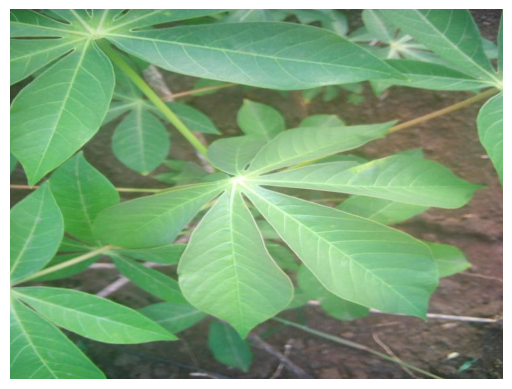

In [10]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = '/Users/alexshienhowkhoo/Documents/SC4000 Project/dataset/train_images'

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [11]:
unique_labels = df_train_data.label.value_counts()
print(unique_labels)
num_unique_labels = unique_labels.index.nunique()
print(num_unique_labels)


label
2    1087
0    1087
4    1087
1    1087
3    1087
Name: count, dtype: int64
5


In [12]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["label"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [13]:
from torch.utils.data import Dataset
import os 
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [15]:
import torch 
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [16]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


In [17]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])
train_df = ConstDataset(df_train, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [18]:
# trainloader = torch.utils.data.DataLoader(train_df, batch_size=4,
#                                           shuffle=True, num_workers=0)
# torch.manual_seed(124)
# for batch_idx, data in enumerate(trainloader,0):
#     if(batch_idx==0): 
#         input, label = data 
#         print(type(input))
#         print(input[0].shape)
#         print(input[0])
#         plt.imshow(input[0].numpy().transpose(1,2,0))
#     break;



In [19]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [20]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=32 * 30 * 30, out_features=128)  # Adjust input size accordingly
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)   # Output layer now has num_classes units

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model (replace num_classes with the actual number of classes in your dataset)
num_classes = 5  # Example: 10 classes
model = CNN(num_classes=num_classes)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multiclass classification


In [22]:
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [23]:
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

In [24]:
#!pip install tensorflow-macos


In [25]:
# Define device (MPS or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

In [26]:
for epoch in range(epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs, labels = inputs.to(device),labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            #MODIFICATIONS
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
  
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.float() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.float() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.6582 Acc: 0.2660
val Loss: 1.4983 Acc: 0.3566


KeyboardInterrupt: 

In [ ]:
# Define the path where you want to save the model
save_path = './trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

In [65]:
#https://pytorch.org/vision/0.9/models.html